In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt, zipfile
import os
import glob
import math
import random
import time
import datetime
import shutil
import pickle
import imageio
from tqdm import tqdm, tqdm_notebook
from dataclasses import dataclass
from pathlib import Path
import warnings
from IPython import display
from scipy import linalg
import xml.etree.ElementTree as ET 
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape,\
Conv2DTranspose, Conv2D, Flatten, Dropout, Embedding, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.engine import *
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils
import tensorflow_datasets as tfds

**load dataset and split into train and validation set**

In [ ]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(train_set, validation_set), info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:70%]', 'train[70%:]'),
    with_info = True,
    as_supervised = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteC78RFF/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


**change all image in same size**

In [ ]:
count = 0
train_images = []
for ex in tfds.as_numpy(train_set):
    count +=1
    if(count%1000==0):
        print(count)
    if(count==16284):
        break
    res = cv2.resize(ex[0], dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
    train_images.append(res)
train_images = np.array(train_images)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


In [ ]:
count = 0
valid_images = []
for ex in tfds.as_numpy(validation_set):
    count +=1
    if(count%1000==0):
        print(count)
    if(count==6980):
        break
    res = cv2.resize(ex[0], dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
    valid_images.append(res)
valid_images = np.array(valid_images)

1000
2000
3000
4000
5000
6000


In [ ]:
train_images.shape

(16283, 96, 96, 3)

In [ ]:
valid_images.shape

(6979, 96, 96, 3)

**plot data**

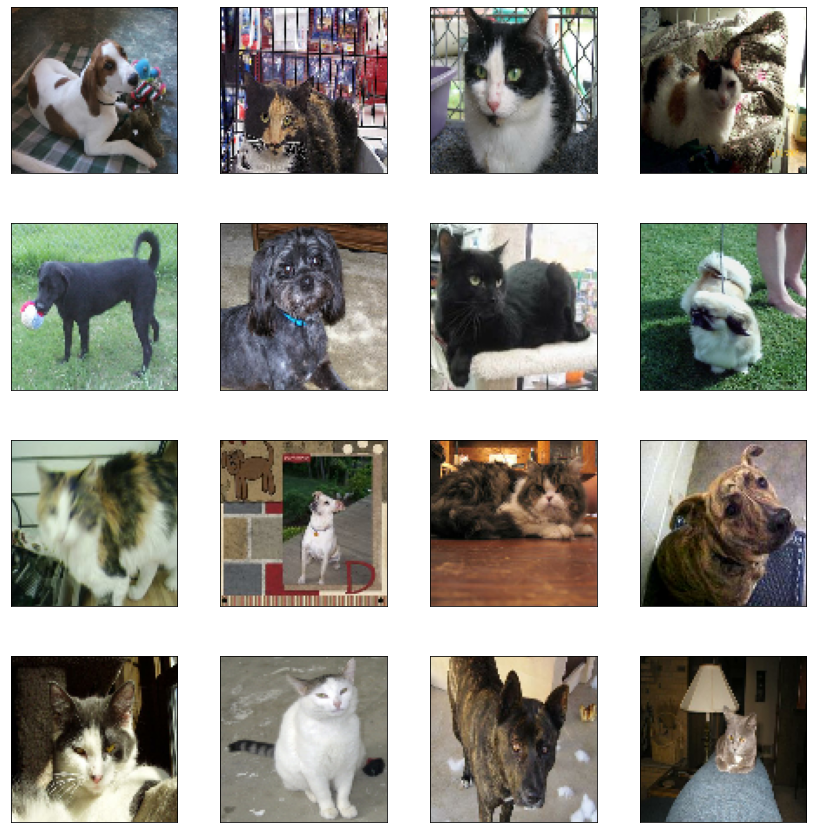

In [ ]:
def plot_features(features,
                examples=9):     
    imgs = []
    for i in range(examples):
        rnd_idx = np.random.randint(0, len(features))
        imgs.append(features[rnd_idx, :, :, :])
    
    
    fig, axes = plt.subplots(round(math.sqrt(examples)), round(math.sqrt(examples)),figsize=(15,15),
    subplot_kw = {'xticks':[], 'yticks':[]},
    gridspec_kw = dict(hspace=0.3, wspace=0.01))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i])
plot_features(train_images, examples=16)

**normalizing**

In [ ]:
train_images = (train_images) / 255  
valid_images - (valid_images )/ 255

array([[[[ 39.84313725,  16.93333333,  32.87058824],
         [ 36.85490196,  11.95294118,  28.88627451],
         [ 38.84705882,   9.96078431,  27.89019608],
         ...,
         [186.26666667, 206.18823529, 228.10196078],
         [185.27058824, 205.19215686, 227.10588235],
         [174.31372549, 193.23921569, 211.16862745]],

        [[ 46.81568627,  22.90980392,  38.84705882],
         [ 43.82745098,  16.93333333,  33.86666667],
         [ 47.81176471,  18.9254902 ,  36.85490196],
         ...,
         [187.2627451 , 202.20392157, 229.09803922],
         [196.22745098, 210.17254902, 237.06666667],
         [170.32941176, 190.25098039, 217.14509804]],

        [[ 42.83137255,  15.9372549 ,  32.87058824],
         [ 45.81960784,  16.93333333,  34.8627451 ],
         [ 48.80784314,  14.94117647,  34.8627451 ],
         ...,
         [172.32156863, 196.22745098, 219.1372549 ],
         [184.2745098 , 206.18823529, 230.09411765],
         [148.41568627, 178.29803922, 204.19607843]],

**shuffle data and batching**

In [ ]:
train_features_data = tf.data.Dataset.from_tensor_slices(train_images).shuffle(1200).batch(128, drop_remainder=True)

In [ ]:
valid_features_data  = tf.data.Dataset.from_tensor_slices(valid_images).shuffle(600).batch(128, drop_remainder=True)

In [ ]:
print(train_features_data)
print(valid_features_data)

<BatchDataset element_spec=TensorSpec(shape=(128, 96, 96, 3), dtype=tf.float64, name=None)>
<BatchDataset element_spec=TensorSpec(shape=(128, 96, 96, 3), dtype=tf.uint8, name=None)>


**produce noise**

In [ ]:
noise_dim = 128
noise = tf.random.normal([1,noise_dim])

**generator**

In [ ]:
image_width = 96
image_height = 96
image_channels = 3

leaky_relu_slope = 0.2
downsize_factor = 2

scale_factor = 4 ** downsize_factor
lr_initial_d = tf.Variable(0.0002)
lr_initial_g = tf.Variable(0.0002)
lr_decay_steps = 1000

weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02, mean=0.0, seed=256) # almost between -1,1

In [ ]:
def generator_model():
    model = Sequential()

    #Dense layer
    model.add(Dense(image_width // scale_factor * image_height // scale_factor * 128,
                    input_shape=(noise_dim,), kernel_initializer=weight_initializer))
    
    model.add(Reshape((image_height // scale_factor, image_width // scale_factor, 64)))

    #transopse convolution layer
    model.add(Conv2DTranspose(512, (5, 5),
                          strides=(1, 1), padding='same', 
                          kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))
    
    #transpose convolution layer
    model.add(Conv2DTranspose(256, (5, 5),
                          strides=(2, 2), padding='same', 
                          kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))
    
    #transpose convolution layer
    model.add(Conv2DTranspose(128, (5, 5),
                          strides=(2, 2), padding='same', 
                          kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())

    #transpose convolution layer
    model.add(Conv2DTranspose(64, (5, 5),
                          strides=(2, 2), padding='same', 
                          kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())

    #transpose convolution layer
    model.add(Conv2DTranspose(32, (5, 5),
                          strides=(2, 2), padding='same', 
                          kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())    

    #Dense layer
    model.add(Dense(3, activation='tanh', kernel_initializer=weight_initializer))

    return model


In [ ]:
generator = generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2304)              297216    
                                                                 
 reshape (Reshape)           (None, 6, 6, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 6, 6, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 6, 6, 512)        2048      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 6, 6, 512)         0         
                                                                 
 dropout (Dropout)           (None, 6, 6, 512)         0

**give noise to generator**

(1, 96, 96, 3)
(1, 128) -0.043539733 1.0046048


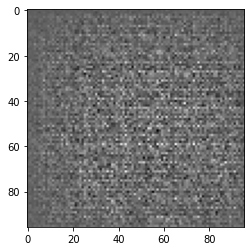

In [ ]:
generate_first_image = generator(noise, training=False)

plt.imshow(generate_first_image[0, :, :, 0], cmap = 'gray')
print(generate_first_image.shape)

print(noise.shape, tf.math.reduce_mean(noise).numpy(), tf.math.reduce_std(noise).numpy())

**Discriminator**

In [ ]:
def discriminator_model(spectral_normalization=False):
    model = Sequential()
    model.add(Conv2D(64, (4, 4), strides=(2,2), padding='same', use_bias=False,
                      input_shape=[image_height, image_width, image_channels], 
                      kernel_initializer=weight_initializer))
    model.add(LeakyReLU(alpha=leaky_relu_slope))

    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))

    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same',
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))

    model.add(Conv2D(256, (4, 4), strides=(2, 2), padding='same',
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [ ]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        65536     
                                                                 
 batch_normalization_5 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       131072    
                                                      

In [ ]:
decision =discriminator(generate_first_image)
print(decision)

tf.Tensor([[0.49999946]], shape=(1, 1), dtype=float32)


**define loss function**

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_initial_g,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_initial_d,beta_1=0.5)

In [ ]:
def discriminator_loss(real_label,fake_label):
    real_loss = cross_entropy(tf.ones_like(real_label), real_label)
    fake_loss = cross_entropy(tf.zeros_like(fake_label), fake_label)
    total_loss = real_loss +  fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_label):
  fake_loss = cross_entropy(tf.ones_like(fake_label),fake_label)
  return fake_loss

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                discriminator=discriminator)

In [ ]:
EPOCHS = 10
num_examples_to_generate = 50
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def train_step(images, loss_type='gan'):
    noise = tf.random.normal([128, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss( fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input, rows, cols):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(14,14))
    for i in range(predictions.shape[0]):
        plt.subplot(rows, cols, i+1)
        plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.)
        plt.axis('off') 
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
display_results = 20
calculate_mifid = 100
replay_step = 25
decay_step = 25
image_output_dir = 'output_images/'
OUT_DIR = Path('output_images/')

def train(dataset, epochs):
    all_gl = np.array([]); all_dl = np.array([])
    
    exp_replay = []
    for epoch in tqdm(range(epochs)):
        
        G_loss = []; D_loss = []
        
        start = time.time()
        new_lr_d = lr_initial_d
        new_lr_g = lr_initial_g
        global_step = 0
        
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            global_step = global_step + 1
            G_loss.append(g_loss); D_loss.append(d_loss)
            all_gl = np.append(all_gl,np.array([G_loss]))
            all_dl = np.append(all_dl,np.array([D_loss]))
        
         
        if (epoch + 1) % display_results == 0 or epoch == 0:
            generate_and_save_images(generator, epoch + 1, seed, rows=10, cols=10)
        
        if (epoch + 1) % calculate_mifid == 0:            
            OUT_DIR.mkdir(exist_ok=True)

        
        if (epoch + 1) % decay_step == 0:
            new_lr_d = tf.keras.experimental.CosineDecay(new_lr_d, min(global_step, lr_decay_steps), lr_decay_steps)
            new_lr_g = tf.keras.experimental.CosineDecay(new_lr_g, min(global_step, lr_decay_steps), lr_decay_steps)
            generator_optimizer = tf.keras.optimizers.Adam(learning_rate=new_lr_d,beta_1=0.5)
            discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=new_lr_g,beta_1=0.5)          

        print('Epoch: {} computed for {} sec'.format(epoch + 1, time.time() - start))
        print('Generator mean_loss : ', np.mean(G_loss),' std: ', np.std(G_loss))
        print('Discriminator mean_loss : ', np.mean(D_loss),' std: ', np.std(D_loss))

        if(epoch%50==0):
            # Generate after every 50th epoch
            # display.clear_output(wait=True)
            # final_seed = tf.random.normal([64, noise_dim])
            
            checkpoint.save(file_prefix = checkpoint_prefix)
    
    generate_and_save_images(generator, epochs, seed, rows=10, cols=10)
    checkpoint.save(file_prefix = checkpoint_prefix)
    
    OUT_DIR.mkdir(exist_ok=True)
    # save_images(OUT_DIR)
    shutil.rmtree(OUT_DIR)
    print('Removed temporary image directory.')
    

In [ ]:
train(train_features_data, EPOCHS)

  0%|          | 0/10 [13:22<?, ?it/s]


KeyboardInterrupt: ignored